# Classifying Sine Waves

## Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Set np seed for consistency
np.random.seed(42)

## Generate Sine Waves

In [54]:
# Function for generating a sine wave with some noise
def generate_sine_wave(freq, sr=22050, duration=1.0, noise=0.0):
    # Generate time axis
    t = np.linspace(0, duration, int(sr*duration), endpoint=False)

    # Generate wave
    wave = np.sin(2 * np.pi * freq * t)

    # Add noise
    wave += noise * np.random.randn(len(t))

    return wave

frequencies = [220, 250, 280, 310, 340, 370, 400, 440, 500, 550, 600, 650, 700, 750, 800, 880]

# Number of sine waves to make per frequency
samples_per_freq = 100

# Noise to add to sine wave
noise = 0.1

X_waves = []
y_labels = []

for label, f in enumerate(frequencies):
    for _ in range(samples_per_freq):
        wave = generate_sine_wave(f, noise=noise)
        X_waves.append(wave)
        y_labels.append(label)

X_waves = np.array(X_waves)
y_labels = np.array(y_labels)


## Extract features using librosa

In [55]:
def extract_features(wave, sr=22050, n_mfcc=13):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)

    # Calculate mean across time so vector is fixed length (average of all MFCC features)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

X_features = np.array([extract_features(wave) for wave in X_waves])

## Train Test Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

## Create Pipelines

In [57]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

## Create Hyperparameter Grids

In [58]:
knn_param_grid = [
    {
        "knn__n_neighbors": np.arange(1, 31),
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2],
    }
]

knn_rnd_search = RandomizedSearchCV(knn_pipeline, param_distributions=knn_param_grid, n_iter=20, cv=5, scoring="accuracy", random_state=42, n_jobs=1)

## Fit Models

In [59]:
knn_rnd_search.fit(X_train, y_train)

print("Best params:", knn_rnd_search.best_params_)
print("Best CV score:", knn_rnd_search.best_score_)

knn_y_pred = knn_rnd_search.predict(X_test)

Best params: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 12}
Best CV score: 0.99921875


## Evaluation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20

    accuracy                           1.00       320
   macro avg       1.00   

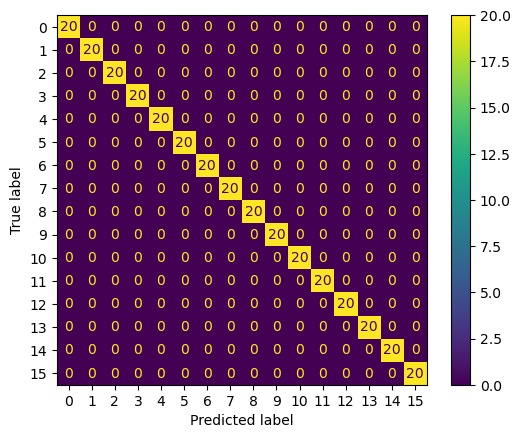

In [60]:
# Get classification report
print(classification_report(y_test, knn_y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_y_pred)
plt.show()